# MNIST Hand Digit Recognition using Tensorflow

Connect Google Drive for saving trained models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Dataset

In [ ]:
BASE_PATH = '/content/drive/My Drive/fiverr/fyzon_36/2022-05-17-tensorflow-mnist'

In [ ]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape data to have a single channel
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# determine the shape of the input images
in_shape = X_train.shape[1:]
print('in_shape:', in_shape)

# determine the number of classes
n_classes = len(np.unique(y_train))
print('n_classes:', n_classes)

# normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# view size of train and test sets
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
in_shape: (28, 28, 1)
n_classes: 10
X_train: (60000, 28, 28, 1)
y_train: (60000,)
X_test: (10000, 28, 28, 1)
y_test: (10000,)


# Create Custom Model

In [ ]:
def create_model():
    # Creating the model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

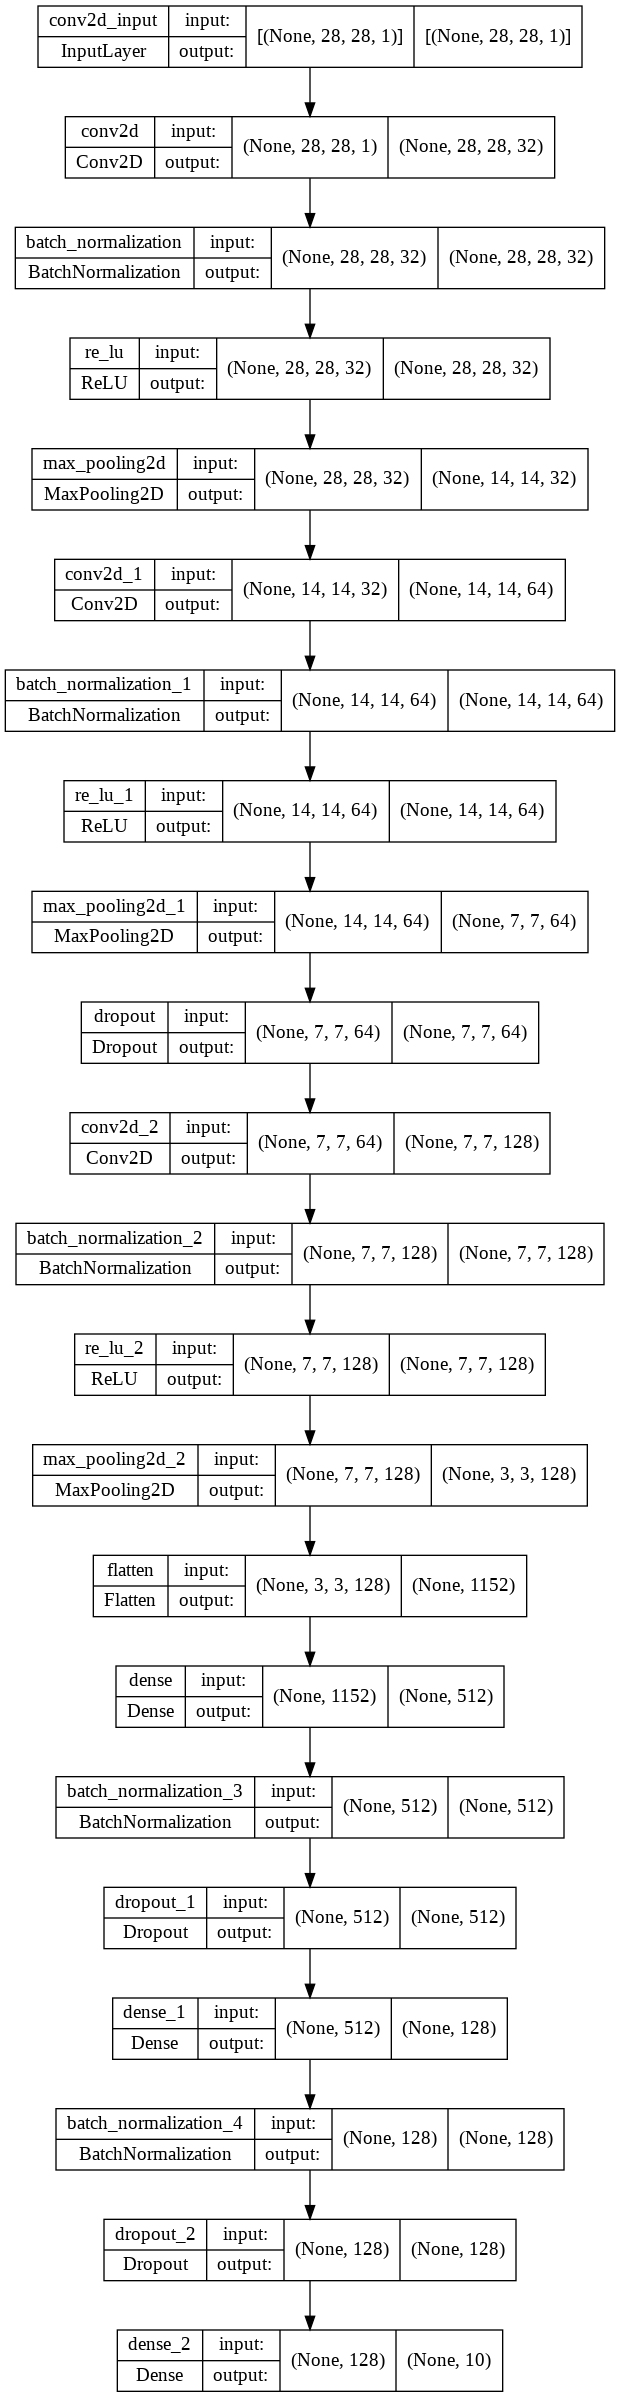

In [ ]:
# clear any tensorflow session to delete models in memory (if any)
clear_session()
# create model object
model = create_model()
# displaying the model in text form
model.summary()
# displaying the model in plot form
plot_model_path = os.path.join(BASE_PATH, 'model-summary.png')
plot_model(model, plot_model_path, show_shapes=True)

# Train Models for 2 learning algorithms and 3 learning rates

In [ ]:
def train_model(model, optimizer_name, learning_rate, X_train, y_train, X_test, y_test):
    # python dictionary to map optimizer_name arguemnt to actual optimizer class
    optimizer_map = {'sgd': SGD, 'adam': Adam}
    # get actual optimizer class from optimizer_name argument
    optimizer_class = optimizer_map[optimizer_name]
    # create tensorflow optimizer object
    optimizer = optimizer_class(learning_rate=learning_rate)

    # define loss and optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # configure early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    # fit the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=1024, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    # evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

    # save model to file
    model_save_path = os.path.join(BASE_PATH, f'model-lr_{learning_rate}-optim_{optimizer_name}.h5')
    model.save(model_save_path)

    return history, test_loss, test_acc


In [ ]:
optimizers = ['sgd', 'adam']
learning_rates = [0.1, 0.01, 0.001]

In [ ]:
# clear any tensorflow session to delete models in memory (if any)
clear_session()

# list to save training related data for each optimizer and learning_rate combination
trained_models_data = []

for optimizer_name in optimizers:
    for learning_rate in learning_rates:
        # create tensorflow model object
        model = create_model()
        history, test_loss, test_acc = train_model(model, optimizer_name, learning_rate, X_train, y_train, X_test, y_test)
        trained_models_data.append([optimizer_name, learning_rate, model, history, test_loss, test_acc])
        print(f'optim={optimizer_name}, lr={learning_rate}, test_acc={test_acc:.4f}, test_loss={test_loss:.4f}')
        print()

print('total trained models:', len(trained_models_data))

Epoch 1/50
47/47 [==============================] - 3s 47ms/step - loss: 0.5072 - accuracy: 0.8444 - val_loss: 2.9041 - val_accuracy: 0.1060
Epoch 2/50
47/47 [==============================] - 2s 42ms/step - loss: 0.1660 - accuracy: 0.9494 - val_loss: 4.4909 - val_accuracy: 0.1060
Epoch 3/50
47/47 [==============================] - 2s 42ms/step - loss: 0.1244 - accuracy: 0.9627 - val_loss: 5.6123 - val_accuracy: 0.1060
Epoch 4/50
47/47 [==============================] - 2s 42ms/step - loss: 0.1048 - accuracy: 0.9680 - val_loss: 6.0270 - val_accuracy: 0.1060
Epoch 5/50
47/47 [==============================] - 2s 42ms/step - loss: 0.0900 - accuracy: 0.9731 - val_loss: 5.8661 - val_accuracy: 0.1060
Epoch 6/50
47/47 [==============================] - 2s 45ms/step - loss: 0.0818 - accuracy: 0.9748 - val_loss: 5.4881 - val_accuracy: 0.1066
Epoch 7/50
47/47 [==============================] - 2s 42ms/step - loss: 0.0736 - accuracy: 0.9776 - val_loss: 3.9919 - val_accuracy: 0.1623
Epoch 8/50
47

# Plot Learning/Training Curves

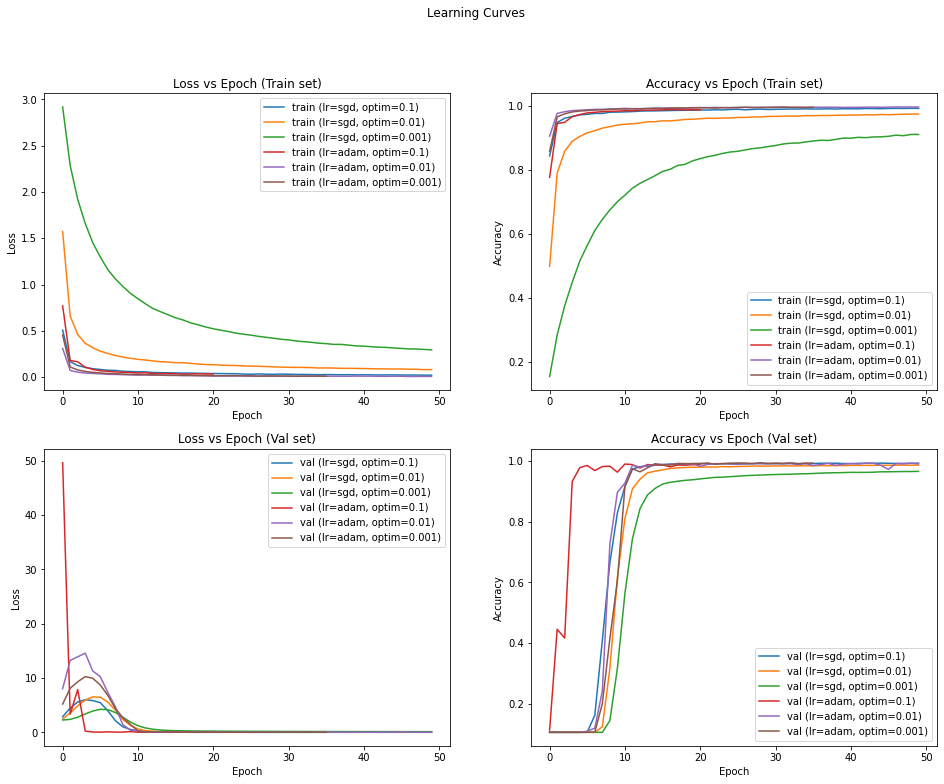

In [ ]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(16.0, 12.0))
fig.suptitle('Learning Curves')
axarr = axarr.ravel()

for trained_model_data in trained_models_data:
    learning_rate, optimizer_name, model, history, test_loss, test_acc = trained_model_data
    label = f'lr={learning_rate}, optim={optimizer_name}'

    axarr[0].plot(history.history['loss'], label=f'train ({label})')
    axarr[0].set_title('Loss vs Epoch (Train set)')
    axarr[0].set(xlabel='Epoch', ylabel='Loss')
    axarr[0].legend()

    axarr[1].plot(history.history['accuracy'], label=f'train ({label})')
    axarr[1].set_title('Accuracy vs Epoch (Train set)')
    axarr[1].set(xlabel='Epoch', ylabel='Accuracy')
    axarr[1].legend()

    axarr[2].plot(history.history['val_loss'], label=f'val ({label})')
    axarr[2].set_title('Loss vs Epoch (Val set)')
    axarr[2].set(xlabel='Epoch', ylabel='Loss')
    axarr[2].legend()

    axarr[3].plot(history.history['val_accuracy'], label=f'val ({label})')
    axarr[3].set_title('Accuracy vs Epoch (Val set)')
    axarr[3].set(xlabel='Epoch', ylabel='Accuracy')
    axarr[3].legend()

savefig_path = os.path.join(BASE_PATH, 'learning-curves.png')
fig.savefig(savefig_path, dpi=150)


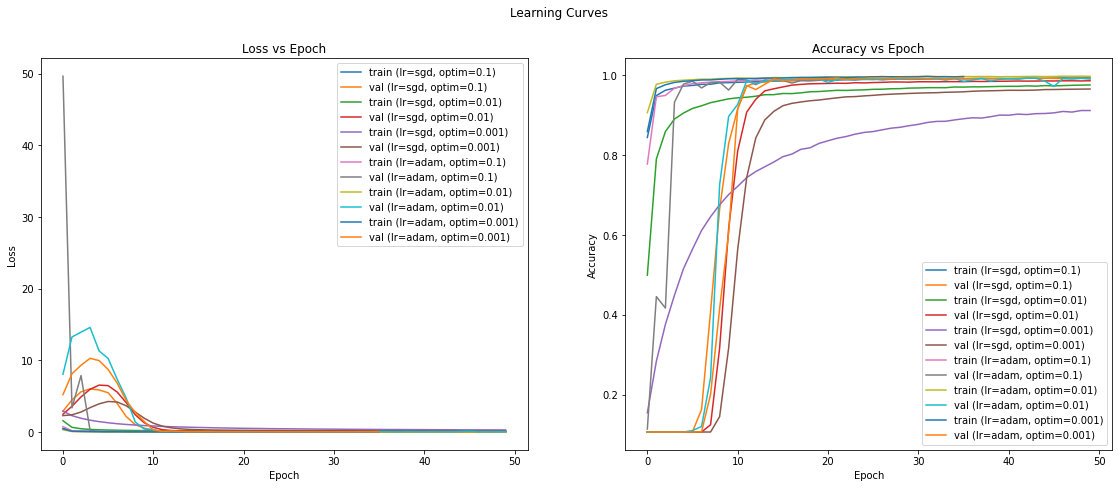

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(19.20, 7.20))
fig.suptitle('Learning Curves')
axarr = axarr.ravel()

for trained_model_data in trained_models_data:
    optimizer_name, learning_rate, model, history, test_loss, test_acc = trained_model_data
    label = f'lr={learning_rate}, optim={optimizer_name}'

    axarr[0].plot(history.history['loss'], label=f'train ({label})')
    axarr[0].plot(history.history['val_loss'], label=f'val ({label})')
    axarr[0].set_title('Loss vs Epoch')
    axarr[0].set(xlabel='Epoch', ylabel='Loss')
    axarr[0].legend()

    axarr[1].plot(history.history['accuracy'], label=f'train ({label})')
    axarr[1].plot(history.history['val_accuracy'], label=f'val ({label})')
    axarr[1].set_title('Accuracy vs Epoch')
    axarr[1].set(xlabel='Epoch', ylabel='Accuracy')
    axarr[1].legend()

# savefig_path = os.path.join(BASE_PATH, 'learning-curves.png')
# fig.savefig(savefig_path, dpi=150)


# Fine-tuning a Pre-trained model

Resize images to 32 by 32, and create 3 channels, this is the input shape required by VGG16 pre-trained model.

In [ ]:
def mnist_32x32(X_28x28):
    X_32x32 = []
    for image in X_28x28:
        resized_image = cv2.resize(image, dsize=(32, 32))
        resized_image = np.dstack([resized_image, resized_image, resized_image])
        X_32x32.append(resized_image)
    X_32x32 = np.array(X_32x32)
    return X_32x32


In [ ]:
X_train_32x32 = mnist_32x32(X_train)
X_test_32x32 = mnist_32x32(X_test)
print('X_train_32x32:', X_train_32x32.shape)
print('X_test_32x32:', X_test_32x32.shape)

X_train_32x32: (60000, 32, 32, 3)
X_test_32x32: (10000, 32, 32, 3)


In [ ]:
vgg16_backbone = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classifier_activation='softmax')
vgg16_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
vgg16_classifier = Sequential()
vgg16_classifier.add(vgg16_backbone)
vgg16_classifier.add(Flatten())
vgg16_classifier.add(Dense(512, activation='relu'))
vgg16_classifier.add(BatchNormalization())
vgg16_classifier.add(Dropout(0.3))
vgg16_classifier.add(Dense(128, activation='relu'))
vgg16_classifier.add(BatchNormalization())
vgg16_classifier.add(Dropout(0.3))
vgg16_classifier.add(Dense(n_classes, activation='softmax'))
vgg16_classifier.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_30 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                      

In [ ]:
history, test_loss, test_acc = train_model(vgg16_classifier, 'adam', 0.001, X_train_32x32, y_train, X_test_32x32, y_test)

Epoch 1/50
47/47 [==============================] - 17s 331ms/step - loss: 1.7597 - accuracy: 0.3831 - val_loss: 351.2866 - val_accuracy: 0.0995
Epoch 2/50
47/47 [==============================] - 15s 327ms/step - loss: 0.6140 - accuracy: 0.7874 - val_loss: 1252.3315 - val_accuracy: 0.1035
Epoch 3/50
47/47 [==============================] - 15s 330ms/step - loss: 0.2088 - accuracy: 0.9425 - val_loss: 37.3878 - val_accuracy: 0.1035
Epoch 4/50
47/47 [==============================] - 16s 332ms/step - loss: 0.1177 - accuracy: 0.9685 - val_loss: 58.4571 - val_accuracy: 0.1035
Epoch 5/50
47/47 [==============================] - 16s 334ms/step - loss: 0.0868 - accuracy: 0.9768 - val_loss: 56.7189 - val_accuracy: 0.1035
Epoch 6/50
47/47 [==============================] - 16s 338ms/step - loss: 0.0697 - accuracy: 0.9810 - val_loss: 46.9883 - val_accuracy: 0.1394
Epoch 7/50
47/47 [==============================] - 16s 340ms/step - loss: 0.0580 - accuracy: 0.9845 - val_loss: 45.9488 - val_accura

In [ ]:
trained_models_data.append(['adam', 0.001, vgg16_classifier, history, test_loss, test_acc])

# Comparision between Custom Model and Fine-tuned VGG16

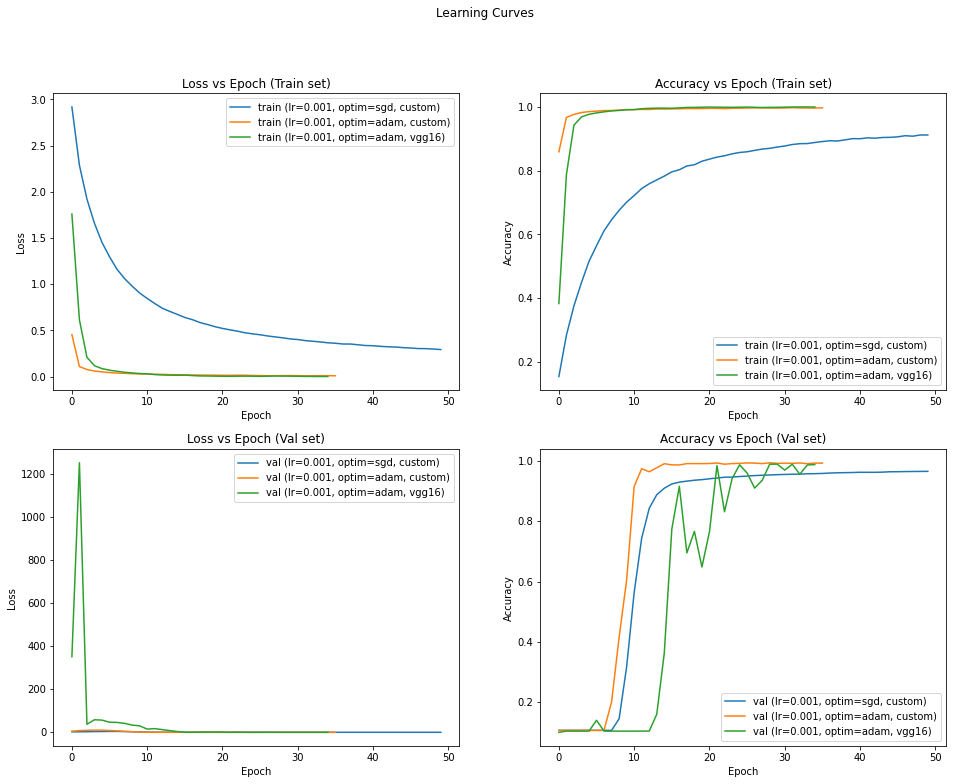

In [ ]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(16.0, 12.0))
fig.suptitle('Learning Curves')
axarr = axarr.ravel()

for idx, trained_model_data in enumerate(trained_models_data):
    optimizer_name, learning_rate, model, history, test_loss, test_acc = trained_model_data
    if learning_rate == 0.001:
        label = f'lr={learning_rate}, optim={optimizer_name}'
        if idx == len(trained_models_data) - 1:
            label = f'{label}, vgg16'
        else:
            label = f'{label}, custom'

        axarr[0].plot(history.history['loss'], label=f'train ({label})')
        axarr[0].set_title('Loss vs Epoch (Train set)')
        axarr[0].set(xlabel='Epoch', ylabel='Loss')
        axarr[0].legend()

        axarr[1].plot(history.history['accuracy'], label=f'train ({label})')
        axarr[1].set_title('Accuracy vs Epoch (Train set)')
        axarr[1].set(xlabel='Epoch', ylabel='Accuracy')
        axarr[1].legend()

        axarr[2].plot(history.history['val_loss'], label=f'val ({label})')
        axarr[2].set_title('Loss vs Epoch (Val set)')
        axarr[2].set(xlabel='Epoch', ylabel='Loss')
        axarr[2].legend()

        axarr[3].plot(history.history['val_accuracy'], label=f'val ({label})')
        axarr[3].set_title('Accuracy vs Epoch (Val set)')
        axarr[3].set(xlabel='Epoch', ylabel='Accuracy')
        axarr[3].legend()

savefig_path = os.path.join(BASE_PATH, 'learning-curves-comparision.png')
fig.savefig(savefig_path, dpi=150)
